# Climate Model Homework
The earth's climate is very complex. "A butterfly flaps its wings in China and it rains in New York" is a popular saying that illustrates the complexity of the climate system. In this homework, we will use a simple climate model to explore the effect of the greenhouse effect on the earth's temperature. 

We'll simulate a layer of dry air on top of a layer of humid air in the troposphere (the air within the first 12km of Earth's surface). Our model will be significantly smaller than the Earth. Oxygen and nitrogen are transparent to both visible and infrared light, but water vapor and carbon dioxide are not. The greenhouse effect is the process by which the atmosphere traps infrared radiation and warms the earth. We need this effect to survive otherwise the earth would be too cold to support life. 

Incoming solar radiation ($I_0$) is absorbed by the different layers, heating them, and some of that energy strikes the Earth's surface. The surface then radiates infrared radiation (I1) back into the atmosphere. Some of this radiation is absorbed by the atmosphere, and some escapes into space. 

Table of Parameters 
|Number|Label|$C_p$, J/mol/K|Reflectivity|Temp, K|Absorption coef., m-1|Emissivity|Thickness, m|Heat transfer coef., kW/m2/K|
|------|-----|-----|----------|----|----------|--------|---------|-------------------|
|1|Dry Air|29|0.02|317|<mark>0.01</mark>|0.3|90|100|
|2|Humid Air|36|0.2|309|<mark>0.7</mark>|0.8|30|100|
|3|Iron|25|0|292|100|0.95|1|1|

The highlighted values are the parameters that will be changing depending on the composition of the dry and humid air.

Energy balance equations that define the behavior and interactions between the layers:

$$
\begin{align}
acc &= in - out \\
\frac{dE_i}{dt} &= n_iC_p^i\frac{dT_i}{dt}= I_{i-1}A_i[(1-r_i)-(1-r_i)^2 e^{-\kappa_i d_i}] -\sigma \epsilon_i A_i(T_i^4-T_{surr}^4) -\sum h_{ij}E_{ij}(T_i-T_j)
\end{align}
$$

where $E$ is the energy stored in each layer, $n$ is the number of moles of each layer, $C_p$ is the heat capacity of each layer, $T$ is the temperature of each layer, $I_0$ is the incoming solar radiation, $A$ is the surface area of the earth, $r$ is the reflectivity of each layer, $\kappa$ is the absorption coefficient of each layer, $d$ is the thickness of each layer, $\sigma$ is the Stefan-Boltzmann constant, $\epsilon$ is the emissivity of each layer, $E$ is the interfacial area, and $h$ is the heat transfer coefficient of each layer.

For example, for the second layer, the above derivative equation is

$$
\frac{dE_2}{dt} = n_2C_p^2\frac{dT_2}{dt}= I_1A_2[(1-r_2)-(1-r_2)^2 e^{-\kappa_2 d_2}] - \sigma \epsilon_2 A_2(T_2^4 - T_{surr}^4) - h_{23}E_{23}(T_2-T_3) - h_{21}E_{21}(T_2-T_1)
$$

The outlet radiation after it passes through a layer is:

$$
I_i = I_{i-1}(1-r_i)^2 e^{-\kappa_i d_i}
$$

An image of the different layers for this model is shown below with the different layers labeled and the incoming radiation through Layer 1. Now we can set up our model in Python.

%<img src="https://github.com/clint-bg/comptools/blob/main/homework/supportfiles/sphere-climate.png?raw=true" width='350'>
<img src="supportfiles/sphere-climate.png" width='350'>

In [1]:
#import dependencies
import param
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt

In [2]:
class layer(param.Parameterized):
    th = param.Number(default=1000, doc="Thickness of the layer, m")
    k = param.Number(default=0, doc="absorbtion coefficient of the layer, m^-1")
    T = param.Number(default=288, doc="Temperature of the layer, K")
    Cp = param.Number(default=1, doc="Heat capacity of the layer, J/(mol K)")
    em = param.Number(default=0.9, doc="Emissivity of the layer")
    sigma = param.Number(default=5.67e-8, doc="Stefan-Boltzmann constant, W/(m^2 K^4)")
    ref = param.Number(default=0.5, doc="Reflectivity of the layer")
    rad = param.Number(default=1, doc="Radius to edge of layer closest to center, m")
    Rg = param.Number(default=8.314, doc="Ideal gas constant, J/(mol K)", constant = True)
    hconv = param.Number(default=10, doc="Convection coefficient, W/(m^2 K)")
    solid = param.Boolean(default=False, doc="Is the layer solid?")
    solidensity  = param.Number(default=1500, doc="Density of the solid, kg/m^3")
    MW = param.Number(default=0.0558, doc="Molecular weight of the component, kg/mol")

    def area(self): #area for the emission to the surroundings taken to be the outside surface area
        return 4*np.pi*(self.rad+self.th)**2

    def moles(self,pressure):
        volume = 4/3*np.pi*((self.rad+self.th)**3 - (self.rad)**3)
        if self.solid:
            return self.solidensity*volume/self.MW
        else:
            return pressure*volume/(self.Rg*self.T)
    
    def adsorbed(self,Ii): # energy adsorbed by the layer
        return Ii*((1-self.ref)-(1-self.ref)**2*np.exp(-self.k*self.th))*self.area() #Ii is the intensity of the incoming radiation
    
    def emitted(self,Tsurr): # energy radiated by the layer to the surroundings
        return self.em*self.sigma*self.area()*(self.T**4 - Tsurr**4)
    
    def convection(self,upperlayer, lowerlayer): # energy convected by the layer to the other layers
        hc_u = (self.hconv + upperlayer.hconv)/2
        hc_l = (self.hconv + lowerlayer.hconv)/2
        area_u = self.area(); area_l = 4*np.pi*(self.rad)**2
        heat_u = hc_u*(self.T - upperlayer.T)*area_u
        heat_l = hc_l*(self.T - lowerlayer.T)*area_l
        return heat_u + heat_l
    
    def dTdt(self,Ii,Tsurr,pressure,upperlayer,lowerlayer): # change in temperature with time of the layer
        conv = self.convection(upperlayer, lowerlayer)
        return (self.adsorbed(Ii) - self.emitted(Tsurr) - conv)/(self.moles(pressure)*self.Cp)    

Task 1: Please describe what the above code is doing. Also please explain what is meant by upperlayer and lowerlayer.




In [3]:
#Now simulate the layers with a given intensity of incoming radiation and 
# a given temperature of the surroundings
years = 5
time = np.linspace(0,365*years,3650*years) #days 
Tsurr = 0 #K
pressure = 1e5 #Pa
hc = 100 #W/(m^2 K) #convection coefficient for all layers
radius = 100 #m, radius of the planet
dryair = layer(th=90, k = 0.01, T = 317, Cp = 29, em = 0.3, ref = 0.02, rad = radius+30+1, hconv = hc)
wetair = layer(th=30, k = 0.7, T = 309, Cp = 36, em = 0.8, ref = 0.2, rad = radius+1, hconv = hc)
iron = layer(th=1, k = 100, T = 292, Cp = 25, em = 0.95, ref = 0, rad = radius, hconv = 1, solid=True)

In [4]:
#set radiation intensity
Io = 1.5e3 #W/m^2
def Ii(day):
    return (np.sin(2*np.pi*day)+1)*Io/2 #W/m^2  

#set absorption coefficient of dryair mimicking increase in CO2 concentration
def ad(day):
    dryair.k += 0.001*0

In [5]:
#Integrate the differential equations using ODEINT
def derivs(T,t,Ii,ad):
    [dryair.T,wetair.T,iron.T] = T #set the temperatures of the layers from the odeint results
    ad(t) #change the absorption coefficient of dryair
    I0 = Ii(t)
    I1 = Ii(t)*(1-dryair.ref)**2*np.exp(-dryair.k*dryair.th)
    I2 = I1*(1-wetair.ref)**2*np.exp(-wetair.k*wetair.th)
    return [dryair.dTdt(I0,Tsurr,pressure,dryair,wetair), \
        wetair.dTdt(I1,Tsurr,pressure,dryair,iron), \
            iron.dTdt(I2,Tsurr,pressure,wetair,iron)]
T0 = [dryair.T,wetair.T,iron.T]
args = (Ii,ad)
results = odeint(derivs,T0,time,args)
first = [each[0] for each in results]
second = [each[1] for each in results]
third = [each[2] for each in results]

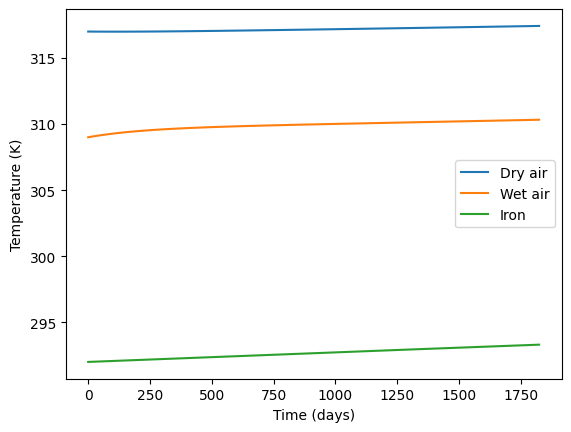

In [6]:
#Plot the results
plt.plot(time,first,label = "Dry air")
plt.plot(time,second,label = "Wet air")
plt.plot(time,third,label = "Iron")
plt.xlabel("Time (days)")
plt.ylabel("Temperature (K)")
plt.legend()
plt.show()

Task 2: Is the above plot reasonable? Why or why not?


If not, what's wrong? If yes, how do you know it's reasonable?






In [7]:
dryair.T,wetair.T,iron.T
#(317.4246435687174, 310.3253407542281, 293.3056373538501)

(317.4246435687174, 310.3253407542281, 293.3056373538501)

Task 3: What is the effect of increasing the absorption coefficient of the humid air layer? Document the effect by comparing the ending temperatures when the absorption coefficient increases linearly as per the above code. Please do so by plotting the temperature vs. the absorption coefficient. Please also explain why this effect occurs.




## Earth's Climate and CO2
Discuss how much money is being spent on carbon capture and other carbon dioxide initiatives. Discuss why and how students need to be able to think critically and make conclusions and estimates for themselves.

Gasonline and diesel consumption for US vehicles
https://www.statista.com/statistics/189410/us-gasoline-and-diesel-consumption-for-highway-vehicles-since-1992/

Greenhouse Gas Index
https://www.climate.gov/news-features/understanding-climate/climate-change-annual-greenhouse-gas-index

Atmospheric CO2 Concentration
https://www.climate.gov/news-features/understanding-climate/climate-change-atmospheric-carbon-dioxide

Global Surface Temperatures
https://www.climate.gov/news-features/understanding-climate/climate-change-global-temperature

What other data would you like to see to corroborate the above data? For example, CxHy + O2 -> CO2 + H2O. Would you expect the concentration of oxygen to increase or decrease?  If the CO2 concentration is increasing, would you expect the density of the atmosphere to increase or decrease?

It's been put forward that the CO2 concentration increase is not only correlated to the apparent rise in the atmospheric temperature but that it is the cause. This cause and effect relationship is not necessarily true, but it may be. How would you go about proving or disproving this?

It has also been put forward that water content in the atmosphere shouldn't be a part of the discussion even though the greenhouse effect of water vapor is much more significant that other gases. What are your thoughts on this?

